In [1]:
import pandas as pd

url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df_red = pd.read_csv(url_red, sep=';')
print(df_red.head())
print(df_red.info())
print(df_red.describe())    

C:\Users\Sean Xander Aquino\AppData\Local\Temp\ipykernel_8932\1051042578.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

Wine type: Red
Total records: 1599
Detected anomalies (bottom 2%): 32


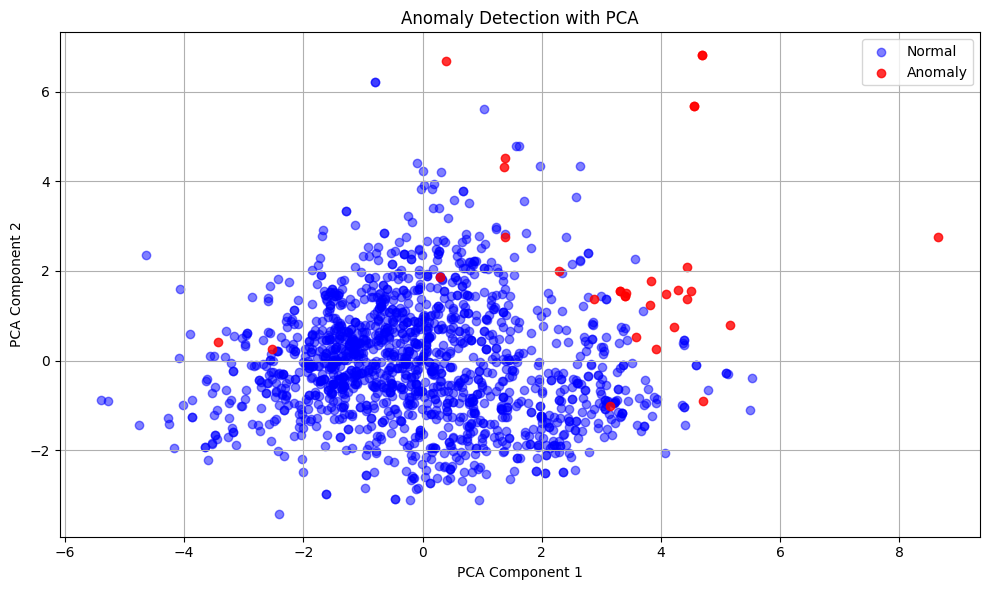

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

def load_wine_data(wine_type='red'):
    """Load wine dataset from UCI based on wine type."""
    url_map = {
        'red': "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
        'white': "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
    }
    url = url_map[wine_type.lower()]
    df = pd.read_csv(url, sep=';')
    return df

def preprocess_data(df):
    """Scale features and separate quality column."""
    X = df.drop(columns=['quality'])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, df

def apply_kmeans(X_scaled, n_clusters=2):
    """Apply KMeans clustering."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    return labels

def compute_gaussian_pdf(X_scaled):
    """Estimate PDF of multivariate normal distribution."""
    mean = np.mean(X_scaled, axis=0)
    cov = np.cov(X_scaled, rowvar=False)
    pdf = multivariate_normal(mean=mean, cov=cov).pdf(X_scaled)
    return pdf

def detect_anomalies(pdf, percentile=2):
    """Return boolean mask for data points below the given percentile threshold."""
    threshold = np.percentile(pdf, percentile)
    return pdf < threshold

def visualize_anomalies(X_scaled, anomalies_mask, title="Anomaly Detection with PCA"):
    """Visualize anomalies in 2D using PCA."""
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[~anomalies_mask, 0], X_pca[~anomalies_mask, 1], 
                c='blue', label='Normal', alpha=0.5)
    plt.scatter(X_pca[anomalies_mask, 0], X_pca[anomalies_mask, 1], 
                c='red', label='Anomaly', alpha=0.8)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_anomaly_detection(wine_type='red', k=2, anomaly_percentile=2):
    """Main function to run the entire anomaly detection pipeline."""
    df = load_wine_data(wine_type)
    X_scaled, df = preprocess_data(df)
    
    labels = apply_kmeans(X_scaled, n_clusters=k)
    df['Cluster'] = labels
    
    pdf = compute_gaussian_pdf(X_scaled)
    anomalies_mask = detect_anomalies(pdf, percentile=anomaly_percentile)
    df['Anomaly'] = anomalies_mask

    print(f"Wine type: {wine_type.capitalize()}")
    print(f"Total records: {len(df)}")
    print(f"Detected anomalies (bottom {anomaly_percentile}%): {anomalies_mask.sum()}")
    
    visualize_anomalies(X_scaled, anomalies_mask)
    
    return df  # Return the dataframe with cluster and anomaly labels

# Example usage:
df_results = run_anomaly_detection(wine_type='red', k=2, anomaly_percentile=2)
# The function will print the number of detected anomalies and show a plot of the PCA results.